In [176]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import log_loss
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier, Pool
from ngboost import NGBClassifier
from ngboost.scores import LogScore, CRPScore
from ngboost.distns import k_categorical
from sklearn.preprocessing import *
from scipy.stats import chisquare, chi2_contingency

from kaggler.model import AutoLGB

- 2021.04.21 : 0.7343 / 0.7380 / 0.7280/ LB = 0.7208692899
- 2021.04.23 : 0.73368 / 0.73638 / 0.7275 / LB = 0.71992
- 2021.05.12 : 0.7345915209634648 / 0.7338605603927837 / 0.7255945858732048 / LB = 0.7176508256
- 2021.05.13 : 0.7344568730216293 / 0.7338603966420789 / 0.727039688444993 / LB = 0.7175965313

### 변수 설명

< features >
    
- gender : 성별
- car: 차량 소유 여부
- reality: 부동산 소유 여부
- child_num: 자녀 수
- income_total: 연간 소득
- income_type: 소득 분류
- edu_type: 교육 수준
- family_type: 결혼 여부
- house_type: 생활 방식
- DAYS_BIRTH: 출생일
- DAYS_EMPLOYED: 업무 시작일(양수값은 고용상태가 아님)
- FLAG_MOBIL: 핸드폰 소유 여부
- work_phone: 업무용 전화 소유 여부
- phone: 전화 소유 여부
- email: 이메일 소유 여부
- occyp_type: 직업 유형													
- family_size: 가족 규모
- begin_month: 신용카드 발급 월


< target >
- credit: 사용자의 신용카드 대금 연체를 기준의 신용도

In [177]:
train = pd.read_csv('train.csv').iloc[:, 1:]
test = pd.read_csv('test.csv').iloc[:, 1:]

In [178]:
train.head(2)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0


In [179]:
test.head(2)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0


#### FLAG_MOBIL 변수는 불필요함.

In [180]:
train.drop('FLAG_MOBIL', axis = 1, inplace = True)
test.drop('FLAG_MOBIL', axis = 1, inplace = True)

In [181]:
train['begin_month'] /= (-12)
test['begin_month'] /= (-12)

In [182]:
train.at[train[train.income_type == 'Student'].index, 'income_type'] = 'Working'
test.at[test[test.income_type == 'Student'].index, 'income_type'] = 'Working'

In [183]:
train.at[train[train.DAYS_EMPLOYED > 20000].index, 'occyp_type'] = 'No job'
test.at[test[test.DAYS_EMPLOYED > 20000].index, 'occyp_type'] = 'No job'

In [184]:
train.DAYS_EMPLOYED = [0 if x > 500 else x for x in train.DAYS_EMPLOYED]
test.DAYS_EMPLOYED = [0 if x > 500 else x for x in test.DAYS_EMPLOYED]

In [185]:
train[['DAYS_BIRTH', 'DAYS_EMPLOYED']] /= (-365)
test[['DAYS_BIRTH', 'DAYS_EMPLOYED']] /= (-365)

In [186]:
train.fillna('Unknown', inplace = True)
test.fillna('Unknown', inplace = True)

In [187]:
train.income_type = ['Working' if x == 'Student' else x for x in train.income_type]
test.income_type = ['Working' if x == 'Student' else x for x in test.income_type]

In [188]:
train['em/bir'] = train.DAYS_EMPLOYED / train.DAYS_BIRTH
test['em/bir'] = test.DAYS_EMPLOYED / test.DAYS_BIRTH

In [189]:
train['gender'] = [1 if x == 'M' else 0 for x in train.gender]
test['gender'] = [1 if x == 'M' else 0 for x in test.gender]

In [190]:
train['car'] = [1 if x == 'Y' else 0 for x in train.car]
test['car'] = [1 if x == 'Y' else 0 for x in test.car]

In [191]:
train['reality'] = [1 if x == 'Y' else 0 for x in train.reality]
test['reality'] = [1 if x == 'Y' else 0 for x in test.reality]

In [192]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,em/bir
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,38.079452,12.901370,0,0,0,Unknown,2.0,0.500000,1.0,0.338801
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,31.178082,4.219178,0,0,1,Laborers,3.0,0.416667,1.0,0.135325
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,52.293151,12.147945,0,1,0,Managers,2.0,1.833333,2.0,0.232305
3,0,0,1,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,41.336986,5.731507,0,1,0,Sales staff,2.0,3.083333,0.0,0.138653
4,0,1,1,0,157500.0,State servant,Higher education,Married,House / apartment,41.197260,5.767123,0,0,0,Managers,2.0,2.166667,2.0,0.139988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,0,0,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,33.093151,5.435616,0,0,0,Core staff,4.0,0.166667,1.0,0.164252
26453,0,0,1,1,180000.0,Working,Higher education,Separated,House / apartment,41.893151,6.780822,0,0,0,Unknown,2.0,3.916667,2.0,0.161860
26454,0,1,0,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,27.621918,5.520548,0,0,0,Core staff,2.0,2.083333,2.0,0.199861
26455,1,0,1,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,27.794521,0.293151,0,0,0,Laborers,1.0,4.916667,2.0,0.010547


In [193]:
#train['bm+db'] = train.DAYS_BIRTH + train.begin_month
#test['bm+db'] = train.DAYS_BIRTH + test.begin_month

In [194]:
#train['it/beg'] = train.begin_month / train.income_total
#test['it/beg'] = test.begin_month / test.income_total

In [195]:
#train['cos_it'] = np.sin(train.income_total)
#test['cos_it'] = np.sin(test.income_total)

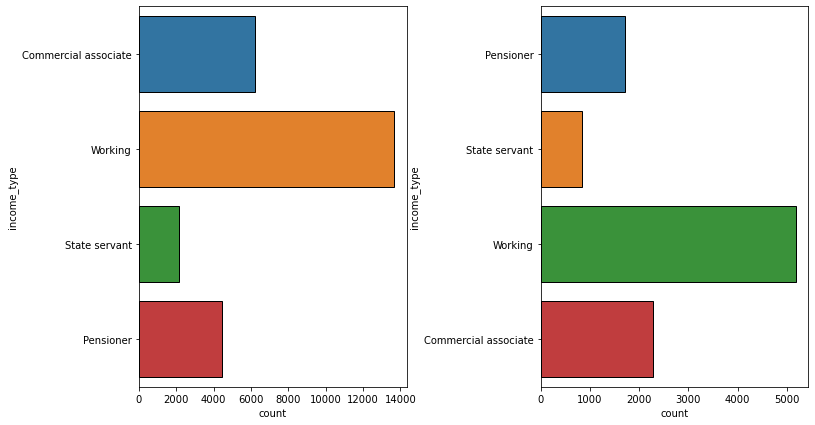

In [196]:
fig, ax = plt.subplots(1, 2, figsize = (12, 7))
plt.subplots_adjust(wspace = .5)
sns.countplot(y = train.income_type, ax = ax[0], edgecolor = (0, 0, 0))
sns.countplot(y = test.income_type, ax = ax[1], edgecolor = (0, 0, 0))
plt.show()

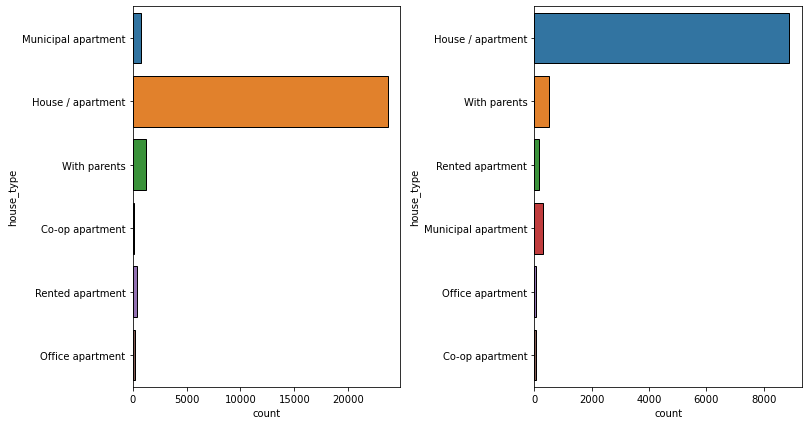

In [197]:
fig, ax = plt.subplots(1, 2, figsize = (12, 7))
plt.subplots_adjust(wspace = .5)
sns.countplot(y = train.house_type, ax = ax[0], edgecolor = (0, 0, 0))
sns.countplot(y = test.house_type, ax = ax[1], edgecolor = (0, 0, 0))
plt.show()

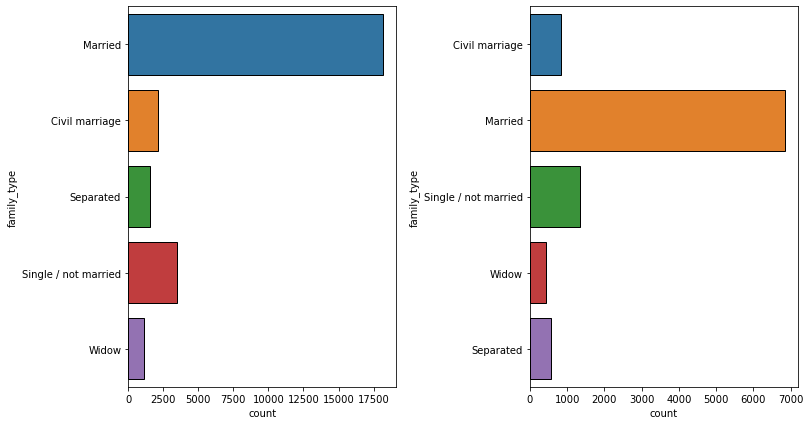

In [198]:
fig, ax = plt.subplots(1, 2, figsize = (12, 7))
plt.subplots_adjust(wspace = .5)
sns.countplot(y = train.family_type, ax = ax[0], edgecolor = (0, 0, 0))
sns.countplot(y = test.family_type, ax = ax[1], edgecolor = (0, 0, 0))
plt.show()

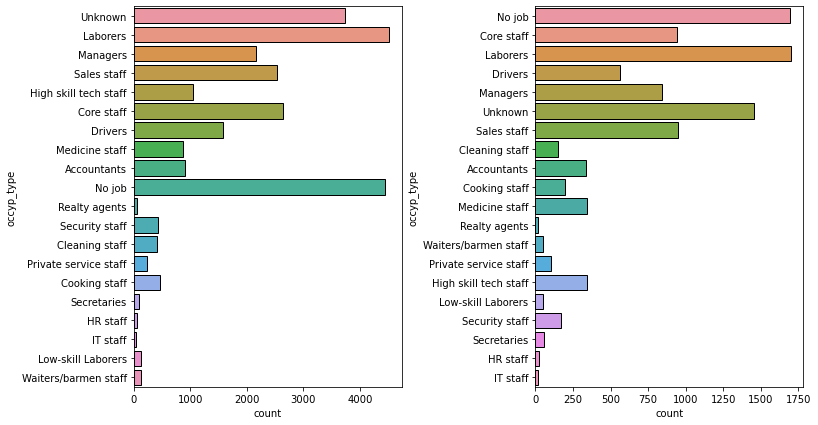

In [199]:
fig, ax = plt.subplots(1, 2, figsize = (12, 7))
plt.subplots_adjust(wspace = .5)
sns.countplot(y = train.occyp_type, ax = ax[0], edgecolor = (0, 0, 0))
sns.countplot(y = test.occyp_type, ax = ax[1], edgecolor = (0, 0, 0))
plt.show()

In [200]:
oc_credit = pd.crosstab(train.occyp_type, train.credit)
oc_credit

credit,0.0,1.0,2.0
occyp_type,,,
Accountants,118,227,557
Cleaning staff,40,93,270
Cooking staff,58,110,289
Core staff,347,622,1677
Drivers,187,358,1030
HR staff,7,4,51
High skill tech staff,123,270,647
IT staff,8,10,23
Laborers,586,1082,2844


In [201]:
oc_credit['sum_oc'] = oc_credit.sum(axis = 1)

In [202]:
oc_credit.iloc[:, 0] = oc_credit.iloc[:, 0].values / oc_credit.sum_oc.values
oc_credit.iloc[:, 1] = oc_credit.iloc[:, 1].values / oc_credit.sum_oc.values
oc_credit.iloc[:, 2] = oc_credit.iloc[:, 2].values / oc_credit.sum_oc.values

In [203]:
oc_credit.reset_index()

credit,occyp_type,0.0,1.0,2.0,sum_oc
0,Accountants,0.130820,0.251663,0.617517,902
1,Cleaning staff,0.099256,0.230769,0.669975,403
2,Cooking staff,0.126915,0.240700,0.632385,457
3,Core staff,0.131141,0.235072,0.633787,2646
4,Drivers,0.118730,0.227302,0.653968,1575
5,HR staff,0.112903,0.064516,0.822581,62
6,High skill tech staff,0.118269,0.259615,0.622115,1040
7,IT staff,0.195122,0.243902,0.560976,41
8,Laborers,0.129876,0.239805,0.630319,4512
9,Low-skill Laborers,0.173228,0.165354,0.661417,127


In [204]:
#train = pd.merge(train, oc_credit.reset_index())
#test = pd.merge(test, oc_credit.reset_index())

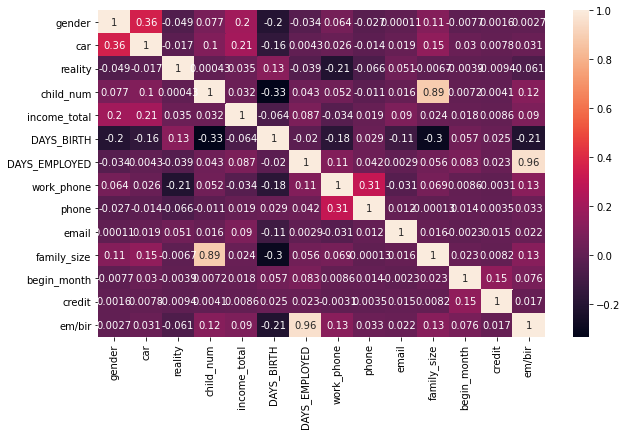

In [205]:
plt.figure(figsize = (10, 6))
sns.heatmap(train.corr(), annot = True)
plt.show()

***

In [206]:
scaler = StandardScaler()

In [207]:
tr_scaled = scaler.fit_transform(train[['DAYS_EMPLOYED', 'em/bir', 'family_size', 'child_num', 'begin_month', 'income_total', 'DAYS_BIRTH']])

In [208]:
te_scaled = scaler.transform(test[['DAYS_EMPLOYED', 'em/bir', 'family_size', 'child_num', 'begin_month', 'income_total', 'DAYS_BIRTH']])

In [209]:
train[['DAYS_EMPLOYED', 'em/bir', 'family_size', 'child_num', 'begin_month', 'income_total', 'DAYS_BIRTH']] = tr_scaled

In [210]:
test[['DAYS_EMPLOYED', 'em/bir', 'family_size', 'child_num', 'begin_month', 'income_total', 'DAYS_BIRTH']] = te_scaled

In [211]:
train2 = pd.get_dummies(columns = train.columns[train.dtypes == 'object'], data = train)


In [212]:
test2 = pd.get_dummies(columns = test.columns[test.dtypes == 'object'], data = test)

In [213]:
skf = StratifiedKFold(n_splits = 8, shuffle = True, random_state = 422)

In [214]:
cat_pred = np.zeros((test2.shape[0], 3))
cat_val_logloss = []
i = 0
for tr_idx, val_idx in skf.split(train2, train2.credit) :
    i += 1
    print(f'=========================={i} FOLD=========================')
    tr_x, tr_y = train2.drop('credit', axis = 1).iloc[tr_idx], train2.credit.iloc[tr_idx]
    val_x, val_y = train2.drop('credit', axis = 1).iloc[val_idx], train2.credit.iloc[val_idx]
    cat = CatBoostClassifier(iterations = 2000, early_stopping_rounds = 500, loss_function = 'MultiClass', random_state = 422, silent = True, depth = 6)
    cat.fit(tr_x, tr_y, eval_set = Pool(val_x, val_y), use_best_model = True)
    val_logloss = cat.best_score_['validation']['MultiClass']
    print(f'Logloss of Validation = {val_logloss}\n')
    cat_val_logloss.append(val_logloss)
    pred = cat.predict_proba(test2) / 8
    cat_pred += pred
print('==========================Finished!=========================\n')
print(f'평균 logloss는 {np.mean(cat_val_logloss)}')

==========================1 FOLD=========================
Logloss of Validation = 0.7302514334235536

==========================2 FOLD=========================
Logloss of Validation = 0.7377208822123161

==========================3 FOLD=========================
Logloss of Validation = 0.7463045570355579

==========================4 FOLD=========================
Logloss of Validation = 0.7532345683667465

==========================5 FOLD=========================
Logloss of Validation = 0.7160959885647848

==========================6 FOLD=========================
Logloss of Validation = 0.7409272182263367

==========================7 FOLD=========================
Logloss of Validation = 0.7218684933154655

==========================8 FOLD=========================
Logloss of Validation = 0.7292428512220366

==========================Finished!=========================

평균 logloss는 0.7344557490458496


In [215]:
lgb_pred = np.zeros((test2.shape[0], 3))
lgb_losses = []
i = 0
for tr_idx, val_idx in skf.split(train2, train2.credit) :
    i += 1
    print(f'========================================{i} FOLD==========================================\n')
    tr_x, tr_y = train2.drop('credit', axis = 1).iloc[tr_idx], train2.credit.iloc[tr_idx]
    val_x, val_y = train2.drop('credit', axis = 1).iloc[val_idx], train2.credit.iloc[val_idx]
    
    lgb = LGBMClassifier(n_jobs = -1, num_iterations = 2500, metric = 'multi_logloss', objective = 'multiclass', n_estimators = 1000, random_state = 422, max_depth = 6)
    
    lgb.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)],
            early_stopping_rounds = 400, verbose = 500, eval_metric = 'multi_logloss')
    print(lgb.best_score_['valid_1']['multi_logloss'])
    lgb_losses.append(lgb.best_score_['valid_1']['multi_logloss'])
    pred = lgb.predict_proba(test2) / 8
    lgb_pred += pred
print('==========================Finished!=========================\n')
print(f'평균 logloss는 {np.mean(lgb_losses)}')

========================================1 FOLD==========================================

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 400 rounds
[500]	training's multi_logloss: 0.465335	valid_1's multi_logloss: 0.731304
Early stopping, best iteration is:
[488]	training's multi_logloss: 0.468797	valid_1's multi_logloss: 0.730822
0.7308223028071885
========================================2 FOLD==========================================

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 400 rounds
[500]	training's multi_logloss: 0.467432	valid_1's multi_logloss: 0.738246
Early stopping, best iteration is:
[473]	training's multi_logloss: 0.476954	valid_1's multi_logloss: 0.736888
0.7368875160351965
============================

In [216]:
xgb_pred = np.zeros((test2.shape[0], 3))
i = 0
xgb_losses = []
for tr_idx, val_idx in skf.split(train2, train2.credit) :
    i += 1
    print(f'=========================={i} FOLD=========================')
    tr_x, tr_y = train2.drop('credit', axis = 1).iloc[tr_idx], train2.credit.iloc[tr_idx]
    val_x, val_y = train2.drop('credit', axis = 1).iloc[val_idx], train2.credit.iloc[val_idx]
    
    xgb = XGBClassifier(n_jobs = -1, objective = 'multi:softprob', n_estimators = 1000, random_state = 422, max_depth = 6)
    
    xgb.fit(tr_x, tr_y, eval_metric = 'mlogloss', eval_set = [(tr_x, tr_y), (val_x, val_y)],
            early_stopping_rounds = 250, verbose = 500)
    p = xgb.predict_proba(val_x, ntree_limit = xgb.best_iteration)
    print(log_loss(val_y, p))
    xgb_losses.append(log_loss(val_y, p))
    pred = xgb.predict_proba(test2, ntree_limit = xgb.best_iteration) / 8
    xgb_pred += pred
print('==========================Finished!=========================\n')
print(f'평균 logloss는 {np.mean(xgb_losses)}')

==========================1 FOLD=========================
[0]	validation_0-mlogloss:0.97426	validation_1-mlogloss:0.97766
[440]	validation_0-mlogloss:0.30372	validation_1-mlogloss:0.74582
0.7216403939771919
==========================2 FOLD=========================
[0]	validation_0-mlogloss:0.97392	validation_1-mlogloss:0.97870
[470]	validation_0-mlogloss:0.28761	validation_1-mlogloss:0.76041
0.7295196409601102
==========================3 FOLD=========================
[0]	validation_0-mlogloss:0.97388	validation_1-mlogloss:0.98007
[442]	validation_0-mlogloss:0.30304	validation_1-mlogloss:0.76127
0.736162670145441
==========================4 FOLD=========================
[0]	validation_0-mlogloss:0.97416	validation_1-mlogloss:0.98135
[427]	validation_0-mlogloss:0.30557	validation_1-mlogloss:0.77764
0.7457196539274094
==========================5 FOLD=========================
[0]	validation_0-mlogloss:0.97513	validation_1-mlogloss:0.97478
[436]	validation_0-mlogloss:0.30214	validation_1-ml

In [217]:
submission = pd.read_csv('sample_submission.csv')

In [223]:
submission.iloc[:, 1:] = xgb_pred * 0.45 +  cat_pred * .35 + lgb_pred * .2

In [224]:
submission

,index,0,1,2
0,26457,0.049113,0.085556,0.865332
1,26458,0.194254,0.199143,0.606603
2,26459,0.057565,0.108342,0.834093
3,26460,0.154271,0.106495,0.739234
4,26461,0.065216,0.219230,0.715555
...,...,...,...,...
9995,36452,0.209763,0.188460,0.601777
9996,36453,0.187189,0.330185,0.482626
9997,36454,0.020712,0.065028,0.914260
9998,36455,0.068465,0.232604,0.698931


In [225]:
submission.to_csv('0419submission.csv', index = False)